In [348]:
import os
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt
import folium
import json

## Cleaning Data

In [311]:
data = pd.read_csv('food-inspections.csv')
data.head()


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2345323,ARMAND'S PIZZERIA,ARMAND'S PIZZERIA,2698587.0,Restaurant,Risk 1 (High),29 N WACKER DR,CHICAGO,IL,60606.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.882700,-87.636638,"{'longitude': '41.88270035458986', 'latitude':...",NaN,NaN,NaN,NaN,NaN
1,2345321,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,CHICAGO,IL,60613.0,...,Pass,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'...",NaN,NaN,NaN,NaN,NaN
2,2345325,TACO MAX MEXICAN GRILL,TACO MAX MEXICAN GRILL,2699082.0,Restaurant,Risk 1 (High),3402 W MONTROSE AVE,CHICAGO,IL,60618.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.961238,-87.713284,"{'longitude': '41.961237630038035', 'latitude'...",NaN,NaN,NaN,NaN,NaN
3,2345370,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,CHICAGO,IL,60622.0,...,No Entry,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':...",NaN,NaN,NaN,NaN,NaN
4,2345376,GARIBAY POULTRY,GARIBAY POULTRY,1908500.0,CUSTOM POULTRY SLAUGHTER,Risk 2 (Medium),2100 S CALIFORNIA AVE,CHICAGO,IL,60608.0,...,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.853688,-87.695652,"{'longitude': '41.85368770723974', 'latitude':...",NaN,NaN,NaN,NaN,NaN


Let's consider only the dataset that contains non NA values for Longitude or Lagitude and we transform the Risk column into an int value column

In [313]:
loc= data[["Latitude","Longitude","AKA Name","Risk"]]
missing = loc[loc.isnull().any(axis = 1)]
data_removed = data.drop(missing.index)
data_removed = data_removed.reset_index()
data_removed["Risk"] = data_removed["Risk"].replace(to_replace =["Risk 3 (Low)", "Risk 2 (Medium)", "Risk 1 (High)","All"],  
                            value =[1,2,3,3]) 
data_removed.Risk = data_removed.Risk.astype(float)
data_removed["Risk"].value_counts()

3.0    139031
2.0     37402
1.0     16192
Name: Risk, dtype: int64

We know create a DataFrame containing all the data we want to plot in function of it Zip code hence we need to groupby zip and create features to our DataFrame

In [379]:
# Count number of failed exams
X = data_removed[data_removed['Results'] == 'Fail'].groupby('Zip')["Results"].count()
#Groupby ZIPS
zip_data = data_removed.groupby("Zip")
#Add all features I can think of
mean_risk = zip_data.Risk.mean()
value_count = data_removed["Zip"].value_counts()
risk_map = pd.DataFrame(mean_risk)
risk_map["Count"] = value_count
risk_map["Fail"] = X
risk_map = risk_map.reset_index()
risk_map["Zip"] = risk_map["Zip"].astype(int)
risk_map = risk_map.fillna(0)
risk_map.head()

,Zip,Risk,Count,Fail
0,60148,3.00000,1,0.0
1,60406,3.00000,1,0.0
2,60501,1.25000,4,3.0
3,60559,1.00000,1,0.0
4,60601,2.71938,3225,403.0


## Having some fun with Folium 

In [306]:
coord = [data_removed["Latitude"][0],data_removed["Longitude"][0]]
m= folium.Map(location= coord,tiles='Stamen Toner', zoom_start=10)


In [307]:
# load GeoJSON
with open('Boundaries - ZIP Codes.geojson', 'r') as jsonFile:
    data = json.load(jsonFile)
tmp = data

# remove ZIP codes not in our dataset
geozips = []
A=[]
for i in range(len(tmp['features'])):
    A.append(int((tmp['features'][i]['properties']['zip'])))
    if A[i] in (risk_map["Zip"].unique()):
        tmp['features'][i]['properties']['zip'] = int((tmp['features'][i]['properties']['zip']))
        geozips.append(tmp['features'][i])
        
# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

# save JSON object as updated-file
open("updated-file.json", "w").write(
    json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
)

5939874

We have created a JSON file containing all information needed for our ZIP code that are given in our data and that can be found also in Boundaries - ZIP Codes.geojson. We get a dataset with 61 entries, better to find one with more ZIP 

In [383]:
def create_map(table, zips, mapped_feature, add_text = ''):
    # reading of the updated GeoJSON file
    geo = r'updated-file.json'
    # initiating a Folium map with LA's longitude and latitude
    m = folium.Map(location = coord, tiles='cartodbpositron',zoom_start = 11)
    # creating a choropleth map
    m.choropleth(
        geo_data = geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'feature.properties.zip',
        # first element contains location information, second element contains feature of interest
        columns = [zips, mapped_feature],
        fill_color = 'BuPu',
        legend_name = (' ').join(mapped_feature.split('_')).title() + ' Number of facilites ' + add_text + ' Across Chigaco'
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    m.save(outfile = mapped_feature + '_map.html')

In [384]:
create_map(risk_map, 'Zip', 'Risk', 'of Facilities')
create_map(risk_map, 'Zip', 'Count', 'of Facilities')
create_map(risk_map, 'Zip', 'Fail', 'of Facilities')


Now Let's look at the HeatMap folium function found on the folium Package

In [281]:
def generateBaseMap(default_location=coord, default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [282]:
from folium.plugins import HeatMap
base_map = generateBaseMap()
HeatMap(data=data_removed[['Latitude', 'Longitude']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map.save("Heatmap of facilities")

## Useless for now

In [299]:
state_geo_path = r"updated-file.json"
geo_json_data = json.load(open(state_geo_path))
m_usa = folium.Map(coord, tiles='cartodbpositron', zoom_start=10)
folium.GeoJson(geo_json_data).add_to(m_usa)
folium.Choropleth(
    geo_data=geo_json_data,
    name='choropleth',
    data=risk_map,
    columns=['Zip', 'Risk'],
    key_on='feature.properties.zip',
    fill_color='BuPu',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Risk given to restaurant'
    
).add_to(m_usa)
folium.LayerControl().add_to(m_usa)
m_usa.save('Marco.html')


In [349]:
fac = (data['Facility Type'].value_counts())
print("The possible results for each facilites are the follwoing with the results given by:")
display(data['Results'].value_counts())

The possible results for each facilites are the follwoing with the results given by:


Pass                    105795
Fail                     37870
Pass w/ Conditions       27105
Out of Business          16844
No Entry                  6237
Not Ready                 1877
Business Not Located        68
Name: Results, dtype: int64

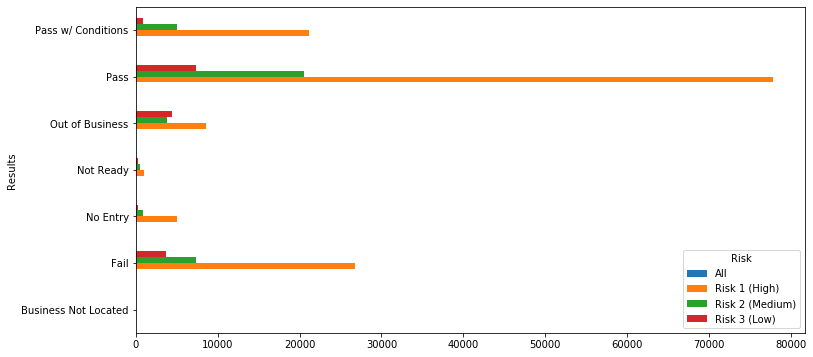

In [350]:
facility = data.groupby("Risk")
facility['Results'].value_counts().unstack(0).plot.barh(figsize=(12,6))
plt.show()